# Noise Reduction - IT24102090
**Member:** Bandara D M R M
**Techniques:** Gaussian, Median, Bilateral, NLM, Morphological
**Input:** Raw dataset images
**Output:** Clean, denoised images
**Metrics:** PSNR, Edge preservation, Noise reduction %

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## Create necessary folders for processing

In [2]:
def create_folder_structure():

    paths = {
        'input_base': Path("/Users/dev/PycharmProjects/Sinhala_Handwriting_Project/data/raw"),
        'output_base': Path("/Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/outputs/processed/IT24102090"),
        'eda_base': Path("/Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/eda_visualizations/IT24102090"),
        'mapping_base': Path("/Users/dev/PycharmProjects/Sinhala_Handwriting_Project/data/mappings")
    }

    for name, path in paths.items():
        path.mkdir(parents=True, exist_ok=True)
        print(f"Created: {path}")

    return paths

folder_paths = create_folder_structure()
print("\nFolder structure ready!")

Created: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/data/raw
Created: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/outputs/processed/IT24102090
Created: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/eda_visualizations/IT24102090
Created: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/data/mappings

Folder structure ready!


## Apply multiple noise reduction techniques

In [3]:
def apply_noise_reduction(image_path):
    try:
        # Read original image
        image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Could not load image: {image_path}")
            return None, None

        # Method 1: Gaussian Blur (removes high-frequency noise)
        gaussian_denoised = cv2.GaussianBlur(image, (3, 3), 0.5)

        # Method 2: Median Filter (removes salt-and-pepper noise)
        median_denoised = cv2.medianBlur(image, 3)

        # Method 3: Bilateral Filter (preserves edges while reducing noise)
        bilateral_denoised = cv2.bilateralFilter(image, 9, 75, 75)

        # Method 4: Non-local Means Denoising
        nlm_denoised = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

        # Method 5: Morphological Operations (remove small artifacts)
        kernel = np.ones((2,2), np.uint8)
        morphological_denoised = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

        # Combined approach: Use bilateral filter as it preserves edges well
        kernel_small = np.ones((1,1), np.uint8)
        final_denoised = cv2.morphologyEx(bilateral_denoised, cv2.MORPH_CLOSE, kernel_small)

        return image, {
            'gaussian': gaussian_denoised,
            'median': median_denoised,
            'bilateral': bilateral_denoised,
            'nlm': nlm_denoised,
            'morphological': morphological_denoised,
            'final': final_denoised
        }

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

## Calculate noise reduction metrics

In [4]:
def calculate_noise_metrics(original, denoised):
    try:
        # Convert to float for calculations
        orig_float = original.astype(np.float32)
        denoised_float = denoised.astype(np.float32)

        # Calculate PSNR (Peak Signal-to-Noise Ratio)
        mse = np.mean((orig_float - denoised_float) ** 2)
        if mse == 0:
            psnr = float('inf')
        else:
            psnr = 20 * np.log10(255.0 / np.sqrt(mse))

        # Calculate noise variance
        noise_variance_orig = np.var(orig_float)
        noise_variance_denoised = np.var(denoised_float)

        # Edge preservation metric
        edges_orig = cv2.Sobel(original, cv2.CV_64F, 1, 1, ksize=3)
        edges_denoised = cv2.Sobel(denoised, cv2.CV_64F, 1, 1, ksize=3)
        edge_preservation = np.corrcoef(edges_orig.flatten(), edges_denoised.flatten())[0,1]

        return {
            'psnr': psnr,
            'noise_variance_original': noise_variance_orig,
            'noise_variance_denoised': noise_variance_denoised,
            'edge_preservation': edge_preservation
        }
    except:
        return {
            'psnr': 0,
            'noise_variance_original': 0,
            'noise_variance_denoised': 0,
            'edge_preservation': 0
        }

## Process sample images for testing

In [5]:
def process_sample_images(class_id=1, max_samples=5):

    # Setup paths
    input_path = folder_paths['input_base'] / "train" / str(class_id)
    output_path = folder_paths['output_base'] / "denoised_train" / str(class_id)
    output_path.mkdir(parents=True, exist_ok=True)

    print(f"Processing Class {class_id}")

    if not input_path.exists():
        print(f"Input path not found: {input_path}")
        return []

    image_files = []
    for ext in ['*.png', '*.jpg', '*.jpeg']:
        image_files.extend(list(input_path.glob(ext)))

    if not image_files:
        print(f"No image files found in {input_path}")
        return []

    processed_data = []
    for i, img_file in enumerate(image_files[:max_samples]):
        print(f"Processing: {img_file.name}")

        original, denoised_results = apply_noise_reduction(img_file)

        if original is not None and denoised_results is not None:
            # Save final denoised image
            output_file = output_path / f"denoised_{img_file.name}"

            # Validate final denoised image before saving
            final_denoised = denoised_results['final']
            if final_denoised is not None and final_denoised.size > 0:
                try:
                    success = cv2.imwrite(str(output_file), final_denoised)
                    if success:
                        # Calculate metrics for the final result
                        metrics = calculate_noise_metrics(original, final_denoised)

                        processed_data.append({
                            'original': original,
                            'denoised_methods': denoised_results,
                            'final_denoised': final_denoised,
                            'filename': img_file.name,
                            'metrics': metrics
                        })

                        print(f"   Saved: {output_file.name} | PSNR: {metrics['psnr']:.2f}")
                    else:
                        print(f"   Failed to save: {output_file.name}")
                except Exception as save_error:
                    print(f"   Error saving {img_file.name}: {save_error}")
            else:
                print(f"   Invalid denoised image for {img_file.name}")
        else:
            print(f"   Failed to process: {img_file.name}")

    print(f"\nProcessed {len(processed_data)} images successfully!")
    return processed_data

# Process sample images
sample_data = process_sample_images(class_id=1, max_samples=5)

Processing Class 1
Processing: ad_mlk30.jpg
   Saved: denoised_ad_mlk30.jpg | PSNR: 33.34
Processing: 39xccd.jpg
   Saved: denoised_39xccd.jpg | PSNR: 51.77
Processing: 29xccd.jpg
   Saved: denoised_29xccd.jpg | PSNR: 55.01
Processing: w48.jpg
   Saved: denoised_w48.jpg | PSNR: 34.18
Processing: ad_mlk31.jpg
   Saved: denoised_ad_mlk31.jpg | PSNR: 33.46

Processed 5 images successfully!


## Create comprehensive denoising comparison

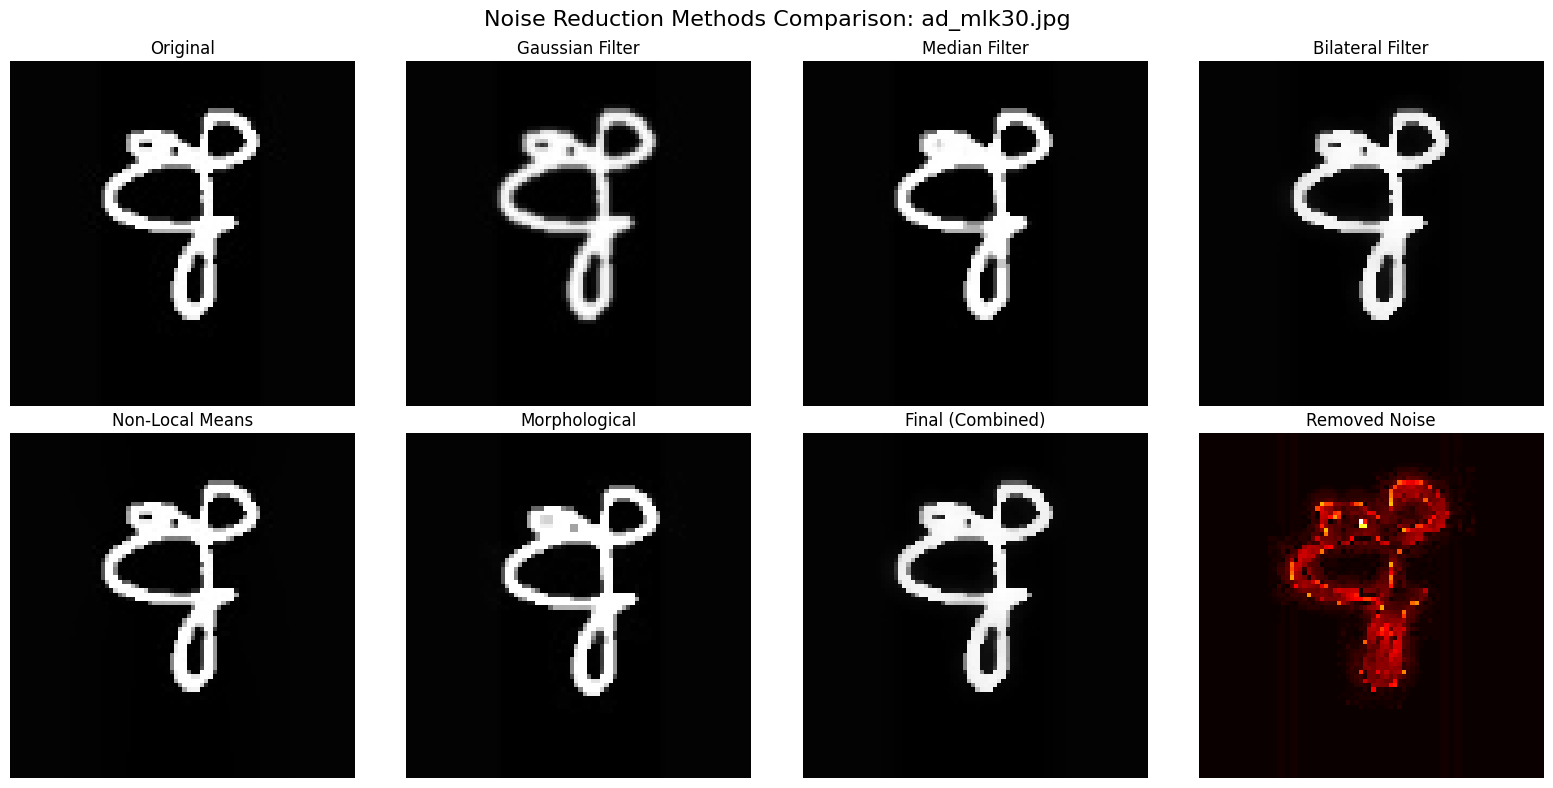

Denoising methods comparison saved: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/eda_visualizations/IT24102090/denoising_methods_comparison.png


In [6]:
def create_denoising_comparison(sample_data):

    if not sample_data:
        print("No sample data available for visualization")
        return

    sample = sample_data[0]  # Use first sample for detailed comparison

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f'Noise Reduction Methods Comparison: {sample["filename"]}', fontsize=16)

    # Original image
    axes[0, 0].imshow(sample['original'], cmap='gray')
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')

    # Gaussian denoising
    axes[0, 1].imshow(sample['denoised_methods']['gaussian'], cmap='gray')
    axes[0, 1].set_title('Gaussian Filter')
    axes[0, 1].axis('off')

    # Median denoising
    axes[0, 2].imshow(sample['denoised_methods']['median'], cmap='gray')
    axes[0, 2].set_title('Median Filter')
    axes[0, 2].axis('off')

    # Bilateral denoising
    axes[0, 3].imshow(sample['denoised_methods']['bilateral'], cmap='gray')
    axes[0, 3].set_title('Bilateral Filter')
    axes[0, 3].axis('off')

    # NLM denoising
    axes[1, 0].imshow(sample['denoised_methods']['nlm'], cmap='gray')
    axes[1, 0].set_title('Non-Local Means')
    axes[1, 0].axis('off')

    # Morphological denoising
    axes[1, 1].imshow(sample['denoised_methods']['morphological'], cmap='gray')
    axes[1, 1].set_title('Morphological')
    axes[1, 1].axis('off')

    # Final result
    axes[1, 2].imshow(sample['denoised_methods']['final'], cmap='gray')
    axes[1, 2].set_title('Final (Combined)')
    axes[1, 2].axis('off')

    # Noise difference
    noise_diff = cv2.absdiff(sample['original'], sample['final_denoised'])
    axes[1, 3].imshow(noise_diff, cmap='hot')
    axes[1, 3].set_title('Removed Noise')
    axes[1, 3].axis('off')

    plt.tight_layout()

    output_file = folder_paths['eda_base'] / 'denoising_methods_comparison.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Denoising methods comparison saved: {output_file}")

create_denoising_comparison(sample_data)

## Analyze denoising effectiveness with metrics

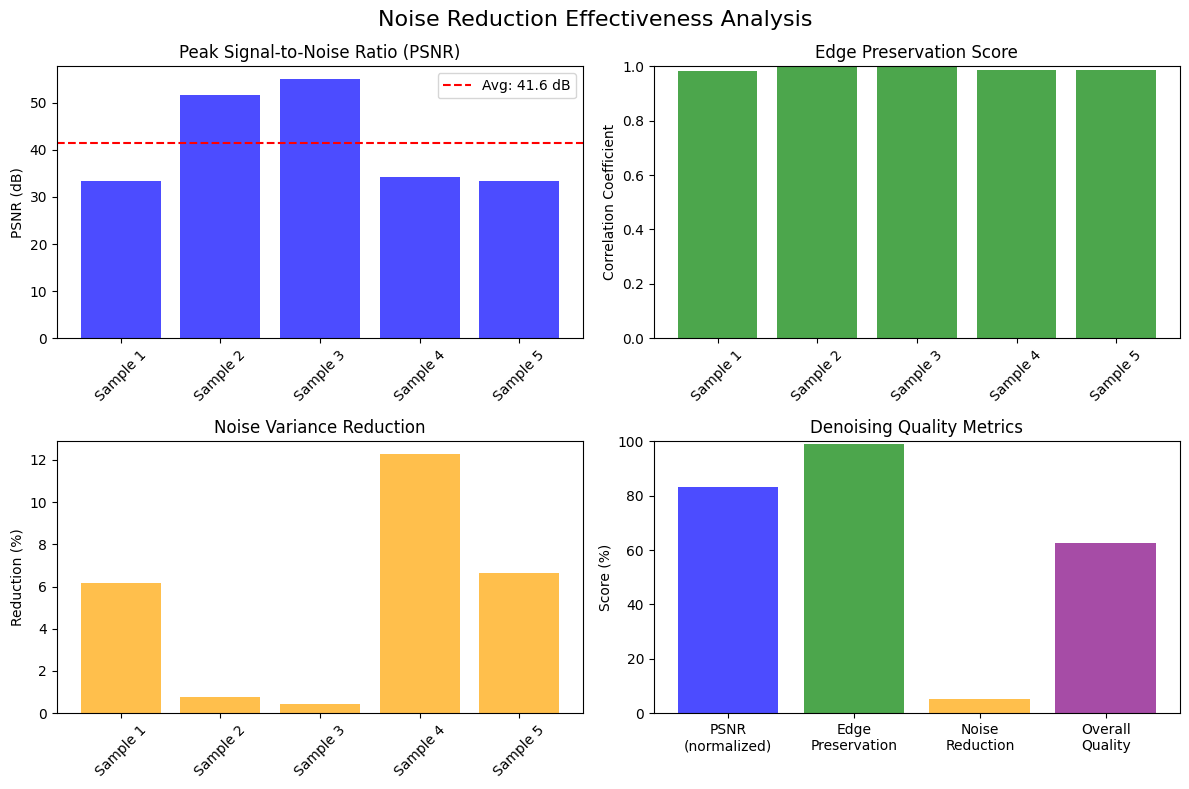

Denoising effectiveness analysis saved: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/eda_visualizations/IT24102090/denoising_effectiveness.png
Average PSNR: 41.55 dB
Average edge preservation: 0.991
Average noise reduction: 5.3%


In [7]:
def analyze_denoising_effectiveness(sample_data):

    if not sample_data:
        print("No data for analysis")
        return {}

    # Extract metrics
    psnr_values = [d['metrics']['psnr'] for d in sample_data]
    edge_preservation = [d['metrics']['edge_preservation'] for d in sample_data]
    noise_reduction = [(d['metrics']['noise_variance_original'] - d['metrics']['noise_variance_denoised'])
                      / d['metrics']['noise_variance_original'] * 100 for d in sample_data]

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Noise Reduction Effectiveness Analysis', fontsize=16)

    # Plot 1: PSNR values
    sample_names = [f"Sample {i+1}" for i in range(len(sample_data))]
    axes[0, 0].bar(sample_names, psnr_values, color='blue', alpha=0.7)
    axes[0, 0].set_title('Peak Signal-to-Noise Ratio (PSNR)')
    axes[0, 0].set_ylabel('PSNR (dB)')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Add average line
    avg_psnr = np.mean(psnr_values)
    axes[0, 0].axhline(y=avg_psnr, color='red', linestyle='--', label=f'Avg: {avg_psnr:.1f} dB')
    axes[0, 0].legend()

    # Plot 2: Edge preservation
    axes[0, 1].bar(sample_names, edge_preservation, color='green', alpha=0.7)
    axes[0, 1].set_title('Edge Preservation Score')
    axes[0, 1].set_ylabel('Correlation Coefficient')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].set_ylim(0, 1)

    # Plot 3: Noise reduction percentage
    axes[1, 0].bar(sample_names, noise_reduction, color='orange', alpha=0.7)
    axes[1, 0].set_title('Noise Variance Reduction')
    axes[1, 0].set_ylabel('Reduction (%)')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Plot 4: Overall quality metrics
    metrics = ['PSNR\n(normalized)', 'Edge\nPreservation', 'Noise\nReduction', 'Overall\nQuality']

    # Normalize PSNR to 0-100 scale for comparison
    normalized_psnr = min(100, np.mean(psnr_values) * 2)
    avg_edge = np.mean(edge_preservation) * 100
    avg_noise_red = np.mean(noise_reduction)
    overall_quality = (normalized_psnr + avg_edge + avg_noise_red) / 3

    scores = [normalized_psnr, avg_edge, avg_noise_red, overall_quality]
    colors = ['blue', 'green', 'orange', 'purple']

    axes[1, 1].bar(metrics, scores, color=colors, alpha=0.7)
    axes[1, 1].set_title('Denoising Quality Metrics')
    axes[1, 1].set_ylabel('Score (%)')
    axes[1, 1].set_ylim(0, 100)

    plt.tight_layout()

    output_file = folder_paths['eda_base'] / 'denoising_effectiveness.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Denoising effectiveness analysis saved: {output_file}")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average edge preservation: {np.mean(edge_preservation):.3f}")
    print(f"Average noise reduction: {np.mean(noise_reduction):.1f}%")

    return {
        'psnr_values': psnr_values,
        'edge_preservation': edge_preservation,
        'noise_reduction': noise_reduction,
        'avg_psnr': avg_psnr
    }

analysis_stats = analyze_denoising_effectiveness(sample_data)

## Create detailed before/after analysis

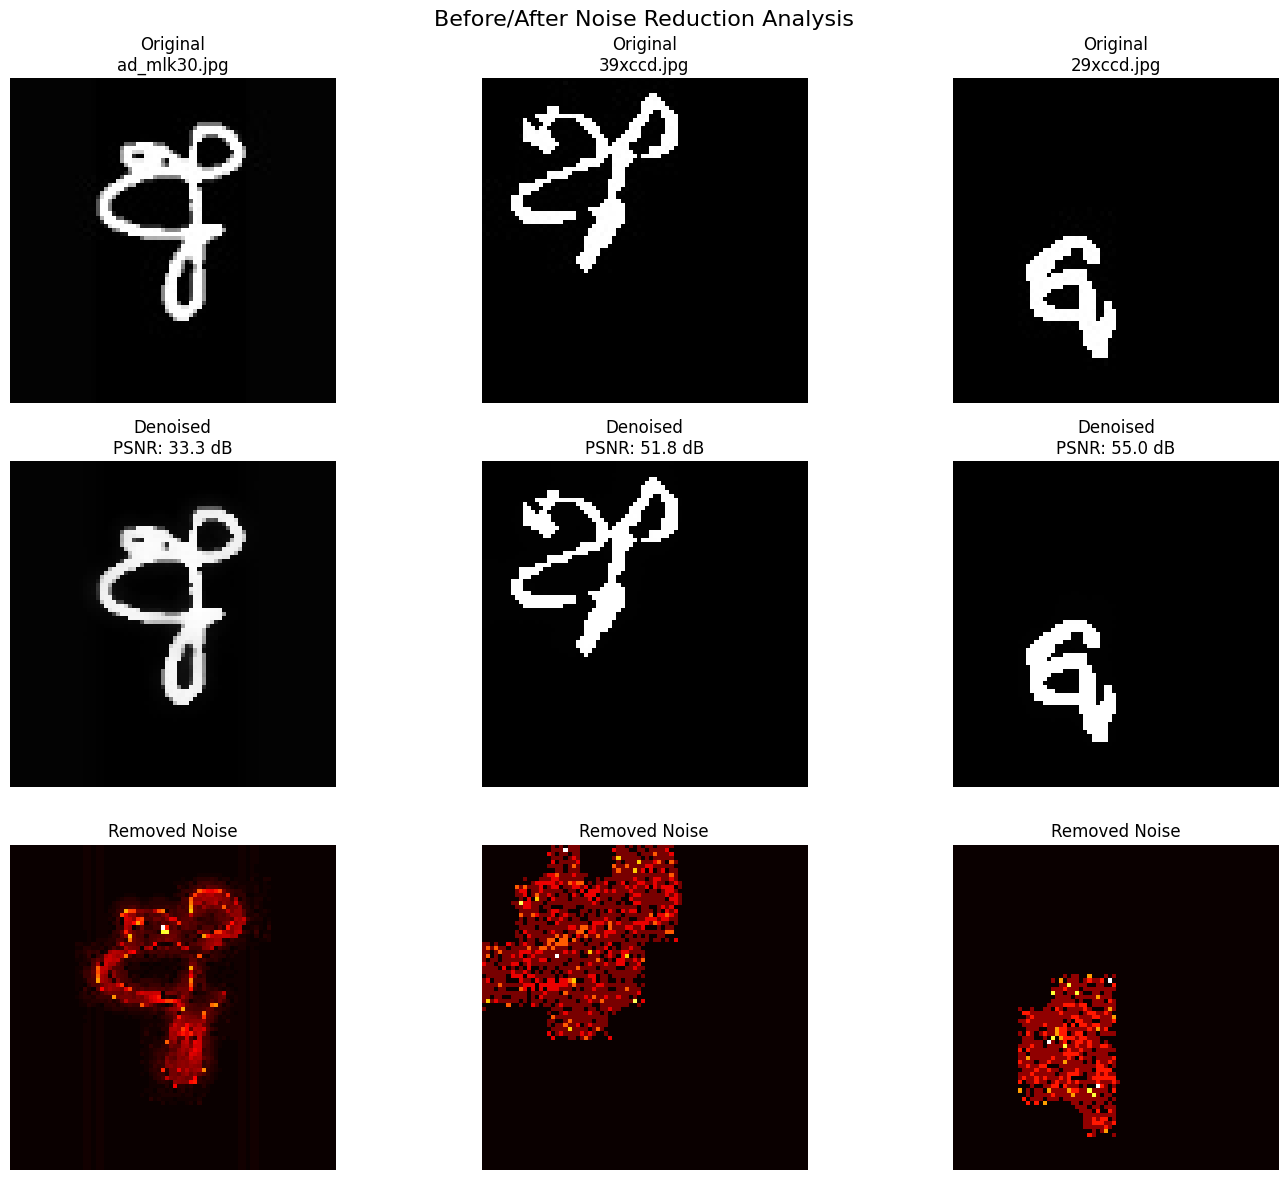

Before/after analysis saved: /Users/dev/PycharmProjects/Sinhala_Handwriting_Project/results/eda_visualizations/IT24102090/before_after_analysis.png


In [8]:
def create_before_after_analysis(sample_data):

    if not sample_data:
        return

    n_samples = min(3, len(sample_data))
    fig, axes = plt.subplots(3, n_samples, figsize=(15, 12))
    fig.suptitle('Before/After Noise Reduction Analysis', fontsize=16)

    if n_samples == 1:
        axes = axes.reshape(3, 1)

    for i in range(n_samples):
        sample = sample_data[i]

        # Original image
        axes[0, i].imshow(sample['original'], cmap='gray')
        axes[0, i].set_title(f'Original\n{sample["filename"]}')
        axes[0, i].axis('off')

        # Denoised image
        axes[1, i].imshow(sample['final_denoised'], cmap='gray')
        axes[1, i].set_title(f'Denoised\nPSNR: {sample["metrics"]["psnr"]:.1f} dB')
        axes[1, i].axis('off')

        # Noise visualization
        noise = cv2.absdiff(sample['original'], sample['final_denoised'])
        axes[2, i].imshow(noise, cmap='hot')
        axes[2, i].set_title('Removed Noise')
        axes[2, i].axis('off')

    plt.tight_layout()

    output_file = folder_paths['eda_base'] / 'before_after_analysis.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Before/after analysis saved: {output_file}")

create_before_after_analysis(sample_data)